# Experiment Design for Operable Space Maximization in a CSTR Cascade Model

Consider the design of experiments for a system of two continuously stirred tank reactors (CSTRs) in series. Pure reactants A and D are fed into the first CSTR and allowed to react. The effluent stream is then fed into the second reactor to react further before being removed for more processing downstream. The system is assumed to operate at steady state with perfect mixing. The desired reaction (formation of B) is kinetically more favorable than the degradation of B and is exothermic.
$$\begin{align}
{\sf A}+{\sf D}\ \stackrel{k_1}{\longrightarrow}\ {\sf B}\ \stackrel{k_2}{\longrightarrow}\ {\sf C}
\end{align}$$
The model equations and parameter values are taken from a case study in [Chen _et al_ (2019)](https://doi.org/10.1002/aic.16214):
$$\begin{align}
0\ =\ & Q_0 (c_{i,k-1}-c_{i,k}) + V_k \sum_{j=1}^{n_{\rm r}} \nu_{i,j}\: r_{j,k}(c_{\cdot,k},T_k), \quad i={\sf A},{\sf B},{\sf C},{\sf D}\\
0\ =\ & \rho\:c_{\rm p}\:Q_0(T_{k-1}-T_k) + V_k \sum_{j=1}^{n_{\rm r}} (-\Delta H_j)\: r_{j,k}(c_{\cdot,k},T_k)\\
& \text{with:}\ k_{j}(T)\ \doteq\ k_{j}^0 \exp\left(-\frac{E_{{\rm a},j}}{T-273}\right)
\end{align}$$
The 6 inputs of interest comprise the concentration of A ($c_{{\sf A},0}$), A:D concentration ratio ($x_{{\sf A:D},0}$), flow rate ($Q_0$) and temperature ($T_0$) of the feed of $\sf CSTR1$, and working volume of both CSTRs ($V_1,V_2$); the 3 outputs consist of the temperature ($T_2$), mole fractions of reactant A ($x_{{\sf A},2}$) and impurity C ($x_{{\sf C},2}$) at the outlet of $\sf CSTR2$.

The impurity mole fraction in the product stream must be kept under 0.002 to remain within specifications. As a measure of reaction completeness, the exit mole fraction of reactant A must remain below 0.02 because there is no recycle in the system. Finally, the exit temperature must be kept under 85 $\sf ^oC$ to prevent degradation of reactant D.
$$\begin{align}
    x_{{\sf A},2} \doteq \frac{c_{{\sf A},2}}{c_{{\sf A},2}+c_{{\sf B},2}+c_{{\sf C},2}+c_{{\sf D},2}}\ & \leq\ 0.02\\
    x_{{\sf C},2} \doteq \frac{c_{{\sf C},2}}{c_{{\sf A},2}+c_{{\sf B},2}+c_{{\sf C},2}+c_{{\sf D},2}}\ & \leq\ 0.002\\
    T_2\ & \leq\ 85\: {\sf ^oC}
\end{align}$$
Within these constraints, the **feasible output space should be explored to as great an extent as possible**.

In [1]:
import numpy as np
import pymc
import cronos

We start by defining the DAG for the dynamic model:

In [2]:
IVPDAG = pymc.FFGraph()
IVPDAG.options.MAXTHREAD = 0

# Controls
CA0  = pymc.FFVar(IVPDAG, "CA0")  # concentration of A in feed of CSTR1 [mol/L]
xAD0 = pymc.FFVar(IVPDAG, "xAD0") # A:D concentration ratio in feed of CSTR1 [mol/L]
Q    = pymc.FFVar(IVPDAG, "Q")    # flow rate [L/h]
T0   = pymc.FFVar(IVPDAG, "T0")   # feed temperature of feed of CSTR1 [oC]
V1   = pymc.FFVar(IVPDAG, "V1")   # volume of CSTR1 [V]
V2   = pymc.FFVar(IVPDAG, "V2")   # volume of CSTR2 [V]

# Parameters
k01 = pymc.FFVar(IVPDAG, "k01")   # reaction rate constant for reaction 1
k02 = pymc.FFVar(IVPDAG, "k02")   # reaction rate constant for reaction 2
Ea1 = pymc.FFVar(IVPDAG, "Ea1")   # activation energy for reaction 1
Ea2 = pymc.FFVar(IVPDAG, "Ea2")   # activation energy for reaction 2
DH1 = pymc.FFVar(IVPDAG, "DH1")   # heat of reaction for reaction 1
DH2 = pymc.FFVar(IVPDAG, "DH2")   # heat of reaction for reaction 2
cp  = pymc.FFVar(IVPDAG, "cp")    # heat capacity of mixture
rho = pymc.FFVar(IVPDAG, "rho")   # density of mixture

# States
CA1 = pymc.FFVar(IVPDAG, "CA1")   # concentration of A in CSTR1 [mol/L]
CB1 = pymc.FFVar(IVPDAG, "CB1")   # concentration of B in CSTR1 [mol/L]
CC1 = pymc.FFVar(IVPDAG, "CC1")   # concentration of C in CSTR1 [mol/L]
CD1 = pymc.FFVar(IVPDAG, "CD1")   # concentration of D in CSTR1 [mol/L]
T1  = pymc.FFVar(IVPDAG, "T1")    # temperature of CSTR1 [oC]
CA2 = pymc.FFVar(IVPDAG, "CA2")   # concentration of A in CSTR2 [mol/L]
CB2 = pymc.FFVar(IVPDAG, "CB2")   # concentration of B in CSTR2 [mol/L]
CC2 = pymc.FFVar(IVPDAG, "CC2")   # concentration of C in CSTR2 [mol/L]
CD2 = pymc.FFVar(IVPDAG, "CD2")   # concentration of D in CSTR2 [mol/L]
T2  = pymc.FFVar(IVPDAG, "T2")    # temperature of CSTR2 [oC]

# Constants
CB0  = pymc.FFVar(IVPDAG, "CB0")  # concentration of B in feed of CSTR1 [mol/L]
CC0  = pymc.FFVar(IVPDAG, "CC0")  # concentration of C in feed of CSTR1 [mol/L]
CD0 = CA0 / xAD0; CD0.set("CD0")

We instantiate `ODESLV` and populate it with the dynamic model expressions:

In [3]:
IVP = cronos.ODESLV()

IVP.set_dag( IVPDAG )
IVP.set_parameter( [CA0, xAD0, Q, T0, V1, V2] )
IVP.set_constant( [k01, k02, Ea1, Ea2, DH1, DH2, cp, rho, CB0, CC0] )
IVP.set_state( [CA1, CB1, CC1, CD1, T1, CA2, CB2, CC2, CD2, T2] )

k11 = k01 * pymc.exp ( - Ea1 / ( T1 + 273.15 ) )
k21 = k02 * pymc.exp ( - Ea2 / ( T1 + 273.15 ) )
r11 = k11 * CA1 * CD1
r21 = k21 * CB1
dCA1 = Q * ( CA0 - CA1 ) + V1 * ( -r11 )
dCB1 = Q * ( CB0 - CB1 ) + V1 * ( r11 - r21 )
dCC1 = Q * ( CC0 - CC1 ) + V1 * ( r21 )
dCD1 = Q * ( CD0 - CD1 ) + V1 * ( -r11 )
dT1  = Q * rho * cp * ( T0 - T1 ) + V1 * ( -r11 * DH1 - r21 * DH2 );

k12 = k01 * pymc.exp ( - Ea1 / ( T2 + 273.15 ) )
k22 = k02 * pymc.exp ( - Ea2 / ( T2 + 273.15 ) )
r12 = k12 * CA2 * CD2
r22 = k22 * CB2
dCA2 = Q * ( CA1 - CA2 ) + V2 * ( -r12 )
dCB2 = Q * ( CB1 - CB2 ) + V2 * ( r12 - r22 )
dCC2 = Q * ( CC1 - CC2 ) + V2 * ( r22 )
dCD2 = Q * ( CD1 - CD2 ) + V2 * ( -r12 )
dT2  = Q * rho * cp * ( T1 - T2 ) + V2 * ( -r12 * DH1 - r22 * DH2 );

IVP.set_differential( [dCA1, dCB1, dCC1, dCD1, dT1, dCA2, dCB2, dCC2, dCD2, dT2] )
IVP.set_initial( [CA0, CB0, CC0, CD0, T0, CA0, CB0, CC0, CD0, T0] )

timegrid = np.linspace( 0, 1e3, 2, True ).tolist()
print( timegrid )
IVP.set_time( timegrid )

IVP.set_function( { 0: CA2 / ( CA2 + CB2 + CC2 + CD2 ),
                    1: CC2 / ( CA2 + CB2 + CC2 + CD2 ),
                    2: T2 } )
print( IVP.eqn_function )

IVP.setup()

[0.0, 1000.0]
[{0: Z77, 1: Z78, 2: T2}]


We solve the dynamic model with initial parameter guesses and record trajectories for display:

In [4]:
IVP.options.DISPLEVEL = 1 # displays numerical integration results
IVP.options.RESRECORD = 200 # record 50 points along time horizon
IVP.solve_state( [ 0.8, 0.8, 0.036, 22.0, 1.743, 1.826 ],
                 [ 2800, 12, 2995, 4427, -80, 0, 1.7, 0.8, 0., 0. ] )

<Status.Normal: 0>

 @t = 0.000000e+00 :
  x[0] = 8.000000e-01
  x[1] = 0.000000e+00
  x[2] = 0.000000e+00
  x[3] = 1.000000e+00
  x[4] = 2.200000e+01
  x[5] = 8.000000e-01
  x[6] = 0.000000e+00
  x[7] = 0.000000e+00
  x[8] = 1.000000e+00
  x[9] = 2.200000e+01
 @t = 1.000000e+03 :
  x[0] = 1.193951e-01
  x[1] = 6.798794e-01
  x[2] = 7.254649e-04
  x[3] = 3.193951e-01
  x[4] = 6.203558e+01
  x[5] = 2.057552e-02
  x[6] = 7.776103e-01
  x[7] = 1.814219e-03
  x[8] = 2.205755e-01
  x[9] = 6.784850e+01
  f[0] = 2.016070e-02
  f[1] = 1.777643e-03
  f[2] = 6.784850e+01
 No STEPS    450
 No EVALATIONS   RHS: 683   JAC: 0
 CPU TIME (SEC)     0.00129



In [5]:
# Gather simulation results
Pred_Exp = []
for rec in IVP.results_state:
    Pred_Exp.append( [rec.t] + rec.x )
Pred_Exp = np.array( Pred_Exp )

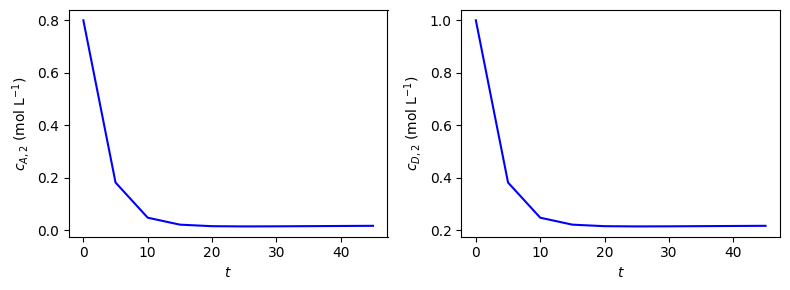

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot( Pred_Exp[0:10,0], Pred_Exp[0:10,6], color="blue" )
axes[0].set(xlabel="$t$")
axes[0].set(ylabel="$c_{A,2}$ (mol L$^{-1}$)")

axes[1].plot( Pred_Exp[0:10,0], Pred_Exp[0:10,9], color="blue" )
axes[1].set(xlabel="$t$")
axes[1].set(ylabel="$c_{D,2}$ (mol L$^{-1}$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
fig.tight_layout()

We embed the dynamic model into DAG operation:

In [7]:
OpIVP = cronos.FFODE()
IVP.options.DISPLEVEL = 0  # turn off display during numerical simulation
IVP.options.RESRECORD = 0  # turn off trajectory record
IVP.options.ATOL, IVP.options.ATOLS, IVP.options.RTOL, IVP.options.RTOLS = 1e-9, 1e-9, 1e-9, 1e-9

Y = OpIVP( [CA0, xAD0, Q, T0, V1, V2], [k01, k02, Ea1, Ea2, DH1, DH2, cp, rho, CB0, CC0], IVP )
IVPDAG.output( Y )


OPERATIONS IN SUBGRAPH:
  CA0	<<  VARIABLE
  xAD0	<<  VARIABLE
  Q	<<  VARIABLE
  T0	<<  VARIABLE
  V1	<<  VARIABLE
  V2	<<  VARIABLE
  k01	<<  VARIABLE
  k02	<<  VARIABLE
  Ea1	<<  VARIABLE
  Ea2	<<  VARIABLE
  DH1	<<  VARIABLE
  DH2	<<  VARIABLE
  cp	<<  VARIABLE
  rho	<<  VARIABLE
  CB0	<<  VARIABLE
  CC0	<<  VARIABLE
  Z79	<<  ODE[0x573fff948d00]( CA0, xAD0, Q, T0, V1, V2, k01, k02, Ea1, Ea2, DH1, DH2, cp, rho, CB0, CC0 )	[0]
  Z80	<<  ODE[0x573fff948d00]( CA0, xAD0, Q, T0, V1, V2, k01, k02, Ea1, Ea2, DH1, DH2, cp, rho, CB0, CC0 )	[1]
  Z81	<<  ODE[0x573fff948d00]( CA0, xAD0, Q, T0, V1, V2, k01, k02, Ea1, Ea2, DH1, DH2, cp, rho, CB0, CC0 )	[2]
DEPENDENTS IN SUBGRAPH:
  0:  Z79
  1:  Z80
  2:  Z81
WORK ARRAY SIZE: 35
MOVE ARRAY SIZE: 16


In [8]:
IVPDAG.eval( Y,
             [CA0, xAD0, Q, T0, V1, V2] + [k01, k02, Ea1, Ea2, DH1, DH2, cp, rho, CB0, CC0],
             [ 0.8, 0.8, 0.036, 22.0, 1.743, 1.826 ] + [ 2800, 12, 2995, 4427, -80, 0, 1.7, 0.8, 0., 0. ] )

[0.020160700910459288, 0.0017776435945915687, 67.84849895952479]

We are now in a position to define the experiment design problem.

In [9]:
from magnus import ExpDes

# Instantiate experiment design solver
ED = ExpDes()
ED.set_dag( IVPDAG )
ED.set_model( Y, [3e-02, 6e-04, 1e3] ); # Scaling is important during to large differences in output magnitude

# Output constraints
G = [ Y[0] - 2e-2, Y[1] - 2e-3, Y[2] - 85 ]
ED.set_constraint( G )

# Nominal parameters and constants
Pnom = [2800, 12, 2995, 4427, -80, 0, 1.7, 0.8 ]
ED.set_parameter( [k01, k02, Ea1, Ea2, DH1, DH2, cp, rho], Pnom )
ED.set_constant( [CB0, CC0], [0.0, 0.0 ] )

# Control space
Ulb = [0.8, 0.8, 0.0083, 22, 0.5, 0.5]
Uub = [1.1, 0.835, 0.08, 35, 2.0, 2.0]
ED.set_control( [CA0, xAD0, Q, T0, V1, V2], Ulb, Uub )


We start by characterizing the feasible domain using nested sampling, drawing $N_{\rm c}=512$ points.

In [10]:
# Sample 512 feasible points
ED.options.CRITERION  = ED.ODIST
ED.options.FEASPROP   = 64
ED.setup()
ED.sample_support( 512 )


** INITIALIZING LIVE POINTS (512)      0.46 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     1.3886e+01     2        0     3.0000e-01
     25     6.2603e-03    14      722     2.2636e-01
     50     2.0031e-03    23     1011     2.0220e-01
     75     1.1744e-03    31     1186     1.8884e-01
    100     8.3080e-04    41     1328     1.7865e-01
    125     7.0406e-04    47     1406     1.7329e-01
    150     5.9199e-04    53     1498     1.6717e-01
    175     4.9542e-04    62     1576     1.6215e-01
    200     4.2953e-04    76     1647     1.5772e-01
    225     3.9384e-04    83     1700     1.5449e-01
    250     3.5882e-04    94     1748     1.5162e-01
    275     3.2867e-04   101     1799     1.4863e-01
    300     3.0655e-04   113     1842     1.4615e-01
    325     2.7165e-04   123     1896     1.4310e-01
    350     2.0951e-04   155     2005     1.3714e-01
    375     1.6744e-04   179     2111     1.3157e

True

In [11]:
# Record output samples
Yini = [ sam[:,0] for sam in ED.output_sample[0] ]
Yini = np.array( Yini )

# Identify min/max output range for scaling
Ymin = Yini.min(axis=0)
Ymax = Yini.max(axis=0)
Yvar = np.power(Ymax-Ymin,2)
print( Yvar )

[1.71410473e-05 1.10049523e-07 2.40053562e+02]


We are now in a position to define the experiment design problem. We consider an initial discretization of the design domain comprising $N_{\rm c}=64$ (Sobol sampled) candidate experiments.

In [12]:
from magnus import ExpDes

# Instantiate experiment design solver
ED = ExpDes()
ED.set_dag( IVPDAG )
ED.set_model( Y, Yvar.tolist() ); # Scaling is important during to large differences in output magnitude

# Output constraints
G = [ Y[0] - 2e-2, Y[1] - 2e-3, Y[2] - 85 ]
ED.set_constraint( G )

# Nominal parameters and constants
Pnom = [2800, 12, 2995, 4427, -80, 0, 1.7, 0.8 ]
ED.set_parameter( [k01, k02, Ea1, Ea2, DH1, DH2, cp, rho], Pnom )
ED.set_constant( [CB0, CC0], [0.0, 0.0 ] )

# Control space
NUSAM = 64;
Ulb = [0.8, 0.8, 0.0083, 22, 0.5, 0.5]
Uub = [1.1, 0.835, 0.08, 35, 2.0, 2.0]
ED.set_control( [CA0, xAD0, Q, T0, V1, V2], Ulb, Uub )

First, we design a campaign with $N_{\rm t} = 8$ experiments that maximizes the spread in output space.

In [13]:
# Set solver options
ED.options.CRITERION                        = ED.ODIST
ED.options.DISPLEVEL                        = 1
ED.options.MINLPSLV.DISPLEVEL               = 1
ED.options.MINLPSLV.MAXITER                 = 100
ED.options.MINLPSLV.NLPSLV.GRADMETH         = ED.options.MINLPSLV.NLPSLV.FAD;
ED.options.MINLPSLV.MIPSLV.DISPLEVEL        = 1
ED.options.MINLPSLV.MIPSLV.INTEGRALITYFOCUS = 0
ED.options.MINLPSLV.MIPSLV.INTFEASTOL       = 1e-9
ED.options.NLPSLV.OPTIMTOL                  = 1e-6
ED.options.NLPSLV.DISPLEVEL                 = 1
ED.options.NLPSLV.GRADMETH                  = ED.options.NLPSLV.FAD
ED.options.NLPSLV.GRADLSEARCH               = 1
ED.options.NLPSLV.FCTPREC                   = 1e-7

# Setup solver
ED.setup()

True

In [14]:
# Sample supports in control domain
ED.sample_support( NUSAM )


** INITIALIZING LIVE POINTS (64)      0.06 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     1.0998e+01     0        0     3.0000e-01
     25     1.1309e-03     3      146     1.9069e-01
     50     3.2920e-04     7      237     1.4349e-01
     75     1.9337e-04    18      277     1.2663e-01
    100     1.0118e-04    30      309     1.1458e-01
    125     2.4041e-05    53      349     1.0112e-01
    140    -2.1447e-07    64      362     9.7092e-02

** EVALUATIONS:       2273 (0 FAILED)
** WALL TIME:         2.25 SEC
** GENERATING SUPPORT SAMPLES     |======================| 64      0.20 SEC


True

In [15]:
# Run combined effort- and gradient-based experiment design
NEXP = 8
ED.combined_solve( NEXP )

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 3599.981277
Set parameter Method to value -1
Set parameter OptimalityTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06
Set parameter IntFeasTol to value 1e-09
Set parameter MIPGap to value 1e-06
Set parameter MIPGapAbs to value 1e-09
Set parameter Heuristics to value 0.05
Set parameter OBBT to value -1
Set parameter MIPFocus to value 0
Set parameter IntegralityFocus to value 0
Set parameter NumericFocus to value 0
Set parameter ScaleFlag to value -1
Set parameter Presolve to value -1
Set parameter LPWarmStart to value 1
Set parameter PreSOS1BigM to value -1
Set parameter PreSOS2BigM to value -1
Set parameter FuncMaxVal to value 1000000
Set parameter DualReductions to value 1
Set parameter NonConvex to value -1
Set parameter Threads to value 0

#  TERMINATION AFTER 0 ITERATION: 0.333 SEC
#  INCUMBENT VALUE:  1.422318e+00
#  INCUMBENT POINT:  1.000000e+00 -0.000000e+00 -0.000000e+00  1.000000e+00
#         

0

In [16]:
# Record output samples
Eopt = ED.effort
Ysam = [ sam[:,0] for sam in ED.output_sample[0] ]
Yopt = [ Ysam[e] for e,r in Eopt.items() ]
Ysam = np.array( Ysam )
Yopt = np.array( Yopt )
print( Eopt, Yopt )

{64: 1.0, 65: 1.0, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0} [[2.00000002e-02 1.78980924e-03 6.78583433e+01]
 [2.00000000e-02 1.73144789e-03 8.50000000e+01]
 [1.50360728e-02 2.00000039e-03 8.50000006e+01]
 [1.99999984e-02 1.99999989e-03 6.78740489e+01]
 [2.00000001e-02 1.58147309e-03 8.50000000e+01]
 [1.81245277e-02 1.99999961e-03 6.79730151e+01]
 [1.71446448e-02 1.99999936e-03 8.49999998e+01]
 [1.99999999e-02 1.99999997e-03 8.50000011e+01]]


[Text(0.5, 0, '$T_2$')]

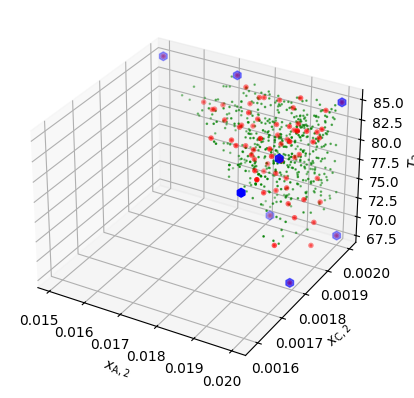

In [20]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(Yini[:,0], Yini[:,1], Yini[:,2], marker='.', s=3, c='g', linewidth=1);
ax.scatter(Ysam[:,0], Ysam[:,1], Ysam[:,2], marker='.', s=15, c='r', linewidth=2);
ax.scatter(Yopt[:,0], Yopt[:,1], Yopt[:,2], s=40, c='b', marker="h", linewidth=1);
ax.set(xlabel="$x_{{\\sf A},2}$")
ax.set(ylabel="$x_{{\\sf C},2}$")
ax.set(zlabel="$T_2$")